In [91]:
%pip install qiskit qiskit_aer pylatexenc
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np


Note: you may need to restart the kernel to use updated packages.


## Steane's 7-qubit code


**Authors: Roberto Hernández Palomares & Lara Ismert**

**Date: July 2, 2025**

In this notebook we recall fundamentals about stabilizer codes and work through encoding $|0_L\rangle$ for Steane's $[[7,1,3]]$ code, introduce random Pauli error, and implement a circuit which detects syndromes and fixes them.

## Preliminaries on Stabilizer Codes

Let $n\in \mathbb{N}$. A CSS code is defined as the fixed space, or intersection of the +1 eigenspace for elements in a *stabilizer group* $S$, which is an abelian subgroup of the Pauli group $P_n$ that does not contain $-I\otimes I\otimes \dots \otimes I$. Given a stabilizer group $S$, define the associated stabilizer code to be
$$
C(S)
=
\{|\psi\rangle\in (\mathbb{C}^2)^{\otimes n}:P|\psi\rangle=|\psi\rangle\,\,\forall P\in S\}.
$$
By virtue of a stabilizer group's defining properties, we can simplify the definition of $C(S)$ as the following: given a generating set $\{g_i\}_{i=1}^m$ of $S$, the stabilizer code is
$$
C(S)
=
\{|\psi\rangle\in (\mathbb{C}^2)^{\otimes n}:g_i |\psi\rangle=|\psi\rangle\,\,\forall i\in [m]\}.
$$
Let $\alpha = i_0i_1\dots i_{n-1}$ be an $n$-bit string (so $i_k\in \{0,1\}$ for all $k$), and for $P\in \{X,Y,Z\}$, define $P_\alpha:= \otimes_{k=0}^{n} i_k P$.

Given $\{0,1\}$-matrices $H_X$ and $H_Z$, known as *check matrices*, of dimension $m\times n$ which satisfy $H_XH_Z^T=0$, we can recover generators $\{X_\alpha,Z_\beta:\alpha\in \text{Row}(H_X),\beta\in \text{Row}(H_Z)\}$, where $\text{Row}(A)$ denotes the row space of a matrix $A$.

## Steane's Code

Consider the check matrices
$$
H_X=H_Z
=
\begin{bmatrix} 1&1&1&1&0&0&0 \\ 1&1&0&0&1&1&0 \\ 1&0&1&0&1&0&1 \end{bmatrix}
$$
which give rise to the stabilizer group $S$ generated by $$\{X_{1111000},X_{1100110},X_{1010101},Z_{1111000},Z_{1100110},Z_{1010101}\}.$$ The code $C(S)$ is called *Steane's Code*.

In [92]:
### We denote both H_X and H_Z by H for Steane's Code.

H = np.array([[1, 1, 1, 1, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0],
              [1, 0, 1, 0, 1, 0, 1]])

print(np.array_equal((H@(H.T))%2, np.zeros((3, 3), dtype=int)))

True


### Encoding for Steane's code

Steane's code encodes a single qubit as a 7-qubit.

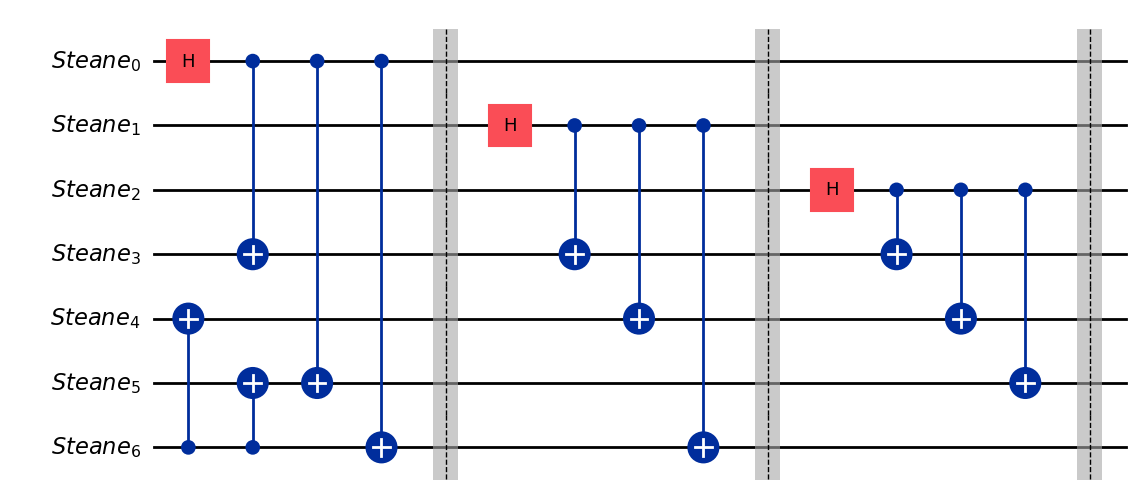

In [93]:
### Encoder taken from https://abdullahkhalid.com/qecft/stabilizer-codes/encoding-circuits-for-stabilizer-codes/
qubits_for_steane = QuantumRegister(size=7, name="Steane")
steane_encode = QuantumCircuit(qubits_for_steane, name="Steane circuit")

steane_encode.h(0)
steane_encode.cx(qubits_for_steane[6],qubits_for_steane[4])
steane_encode.cx(qubits_for_steane[6],qubits_for_steane[5])
steane_encode.cx(qubits_for_steane[0],qubits_for_steane[3])
steane_encode.cx(qubits_for_steane[0],qubits_for_steane[5])
steane_encode.cx(qubits_for_steane[0],qubits_for_steane[6])
steane_encode.barrier()
steane_encode.h(1)
steane_encode.cx(qubits_for_steane[1],qubits_for_steane[3])
steane_encode.cx(qubits_for_steane[1],qubits_for_steane[4])
steane_encode.cx(qubits_for_steane[1],qubits_for_steane[6])
steane_encode.barrier()
steane_encode.h(2)
steane_encode.cx(qubits_for_steane[2],qubits_for_steane[3])
steane_encode.cx(qubits_for_steane[2],qubits_for_steane[4])
steane_encode.cx(qubits_for_steane[2],qubits_for_steane[5])
steane_encode.barrier()


## Let's define our encoder and decoder circuits.

steane_decode = steane_encode.inverse()

steane_encode.draw(output = 'mpl')

In [94]:
### To check Encoder appropriately encodes $|0\rangle$
Statevector(steane_encode).draw("Latex")

<IPython.core.display.Latex object>

In [95]:
#steane_code.compose(steane_encoder, inplace=True)
qubits_for_steane = QuantumRegister(size=7, name="Steane")
steane_code = QuantumCircuit(qubits_for_steane)
steane_code.compose(steane_encode, inplace=True)
steane_code.compose(steane_decode, inplace=True)

Statevector(steane_code).draw("Latex")

<IPython.core.display.Latex object>

We got back the all-zero ket; that means our decoding circuit is working.

## Simulating error from a noisy quantum channel

Suppose our transmitted code $|0_L\rangle$ ends up with some error, such as a single bit flip, or, more generally, a Pauli error on a single qubit. We simulate this below.

In [96]:
# Let's redefine our data qubit register and Steane code circuit.
# This is the last time we will redefine the circuit for this type of error.

qubits_for_steane = QuantumRegister(7, name = "Steane")
steane_code = QuantumCircuit(qubits_for_steane)
steane_code.compose(steane_encode, inplace=True) 

In [97]:
### Error determined by user

# Single qubit flip

steane_code.x(3) #choose your qubit out of 0,1,2,3,4,5,6
#steane_code.x(4)

### Single phase flip #choose your qubit out of 0,1,2,3,4,5,6

steane_code.z(5)

### Observe how the state vector displays the bit flip

Statevector(steane_code).draw("Latex")


<IPython.core.display.Latex object>

In [98]:
Statevector(steane_code).draw("Latex")
### Note: Reading register from bottom to top yields computational basis vectors read from left to right

<IPython.core.display.Latex object>

The vector above is our corrupted code word, $E\ket{\psi_L}$, where $E$ stands for {\em error},
and can be interpreted formally as a quantum operation which transforms the originally encoded
word $\ket{\psi_L}$ by some error (here, single Pauli matrices on different qubits).

## Syndrome Detection

For each generator of the stabilizer group, there is an associated *syndrome*, which is an ancilla qubit that, after running the syndrome circuit, stores parity check information **without changing the code**. Measuring the three ancilla three qubits for the $X$ syndromes (or $Z$ syndromes) tells us the specific error that occurred.

Measuring $000$ means no error occurred, while any of the other 7 bit strings of length 3 gives insight as to what the error was. The syndrome circuit we construct for Steane's code can detect single X (bit flip) and single Z (phase flip) errors on any one qubit.

Just as the rows of $H$ correspond to generators of the stabilizer group, the columns correspond to possible $X$ and $Z$ syndromes we may detect.

\begin{align}
    7 = \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix}   \mapsto x_0=z_0, \qquad
    6 = \begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}   \mapsto x_1=z_1, \qquad
    5 = \begin{pmatrix} 1 \\ 0 \\ 1 \end{pmatrix}   \mapsto x_2=z_2, \qquad \\
    4 = \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}   \mapsto x_3=z_3, \qquad
    3 = \begin{pmatrix} 0 \\ 1 \\ 1 \end{pmatrix}   \mapsto x_4=z_4, \qquad
    2 = \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}   \mapsto x_5=z_5, \qquad
    1 = \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}   \mapsto x_6=z_6,
\end{align}

Recall that the syndrome circuit corresponding to generator $X_{\text{row}}$ or $Z_{\text{row}}$ of the check matrix $H$ is constructed via controlled $X$ and controlled $Z$ gates, respectively. For the ancilla qubit storing the syndrome associated to $X_{1111000}$, for example, we would apply four controlled X gates whose controls are indexed by the entries of the row which are 1 and the target qubit is the designated ancilla for the syndrome. Similarly, we apply controlled $Z$ gates corresponding to $Z_{\text{row}}, but our code does this in a slick way by recalling that $HXH=Z$ and $H^{\otimes 2}CXH^{\otimes 2}$ flips the control and target bits from the original $CX.$

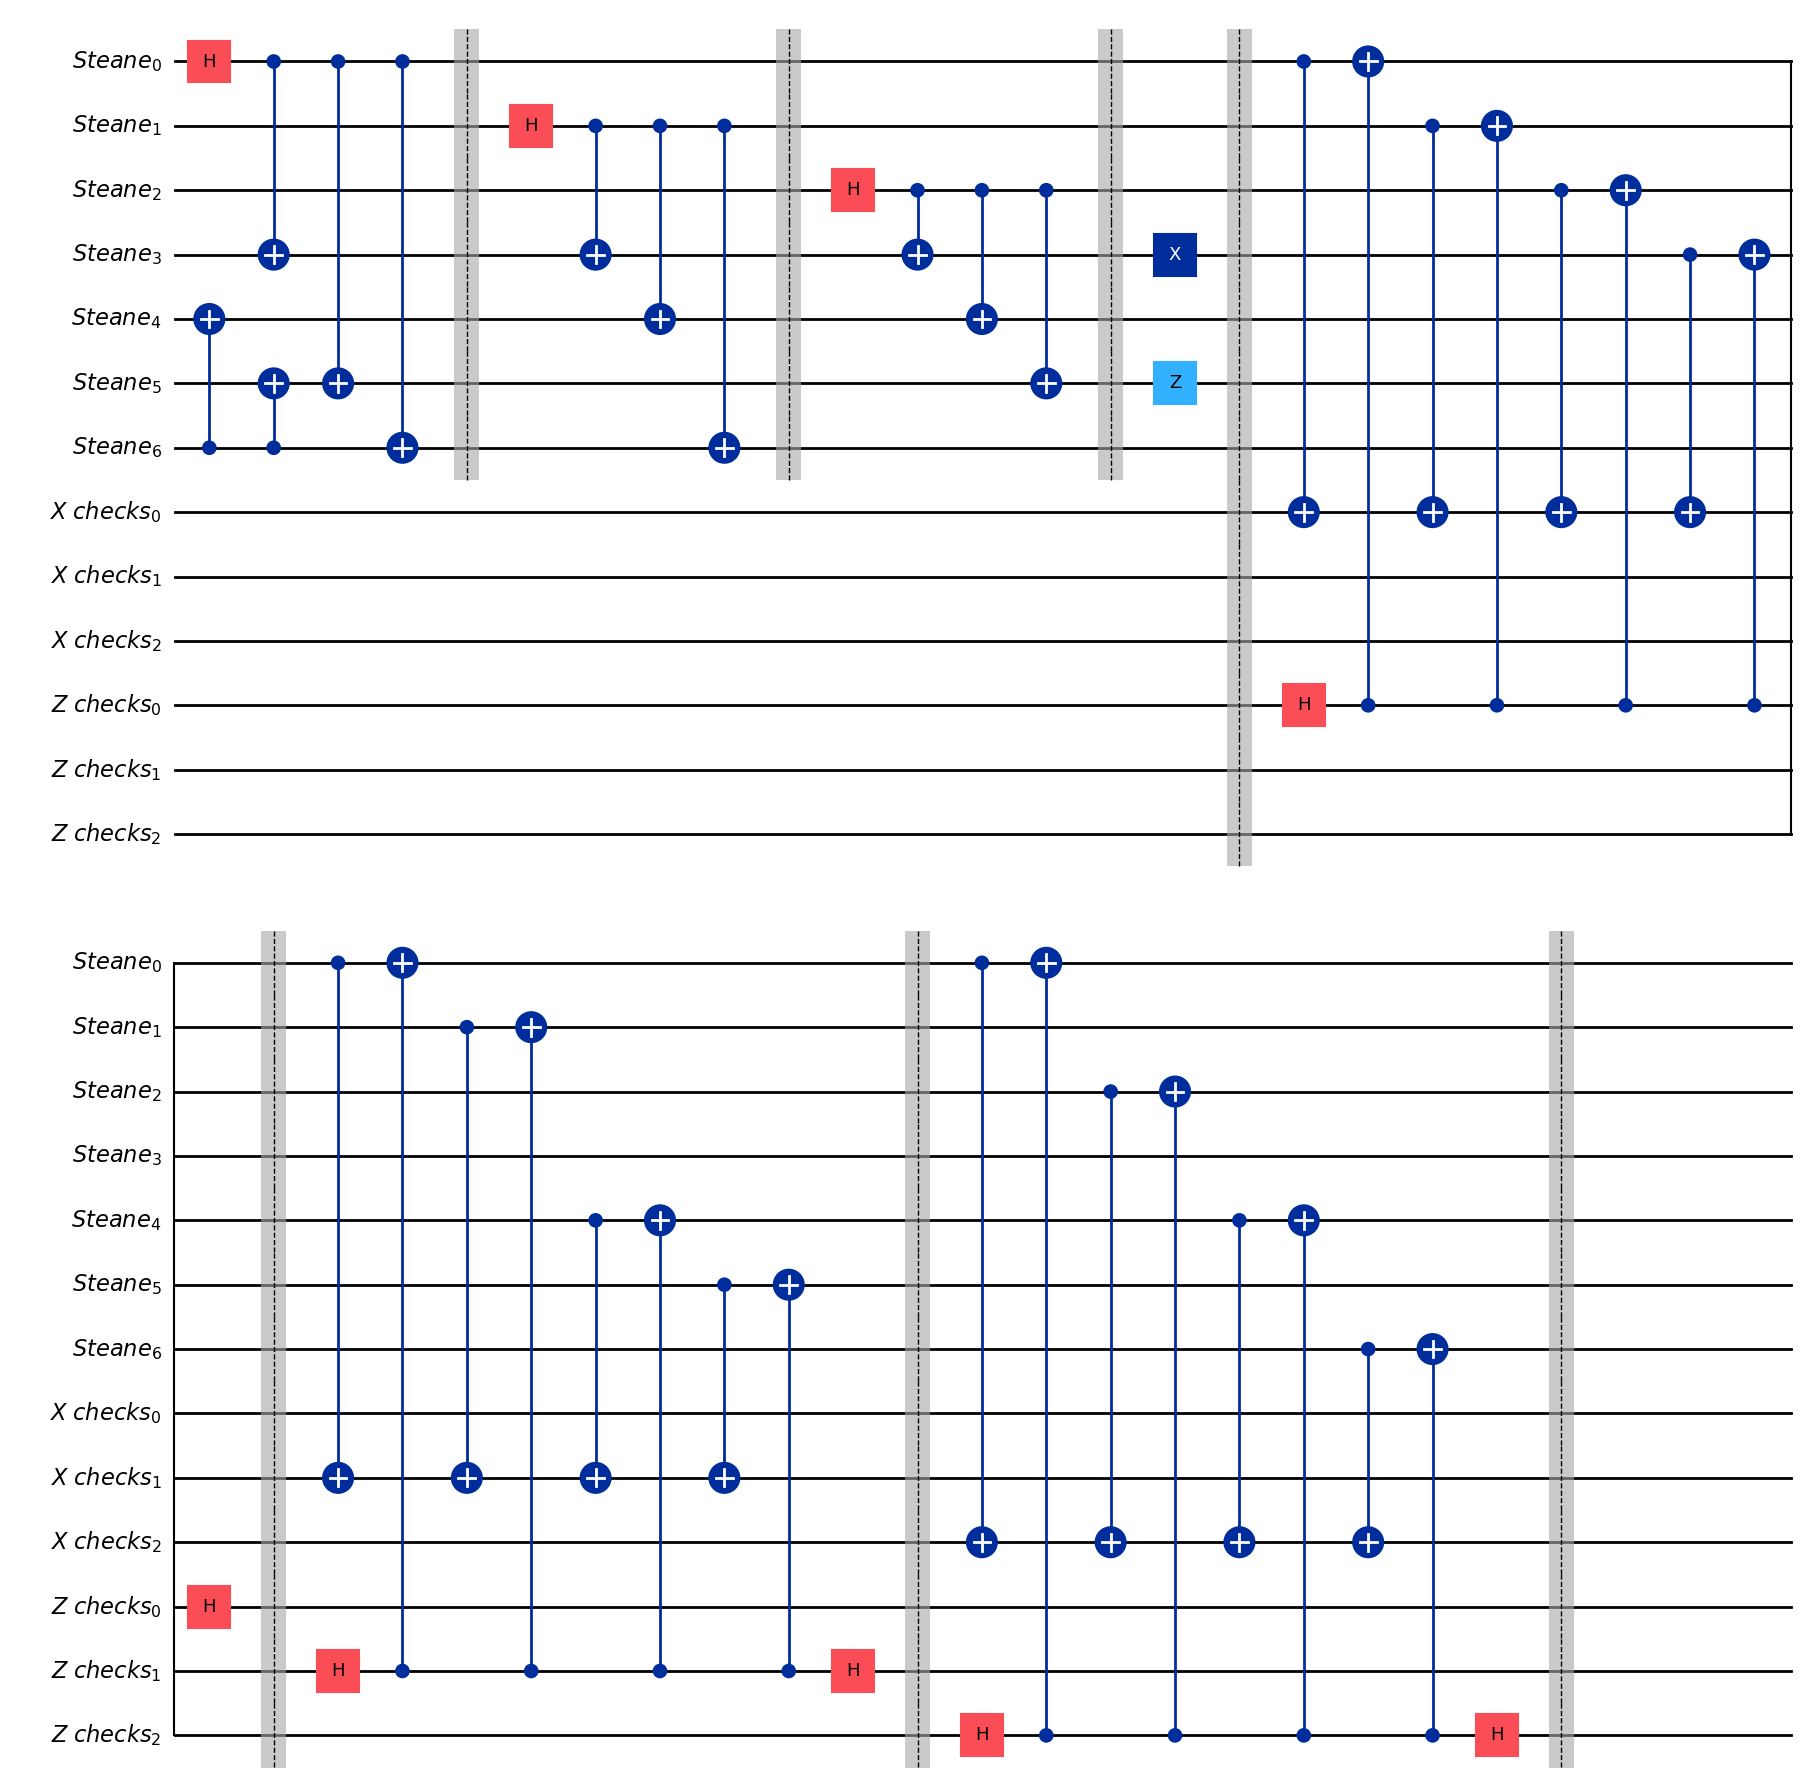

In [99]:
# Adding ancillas for syndromes
qubits_for_X_checks = AncillaRegister(size=3, name=f"X checks")
qubits_for_Z_checks = AncillaRegister(size=3, name=f"Z checks")
### Is it not necessary to add another layer to correct Y errors since
### XZ = -ZX = iY, the X and Z correction will take care of it as is.

steane_code.add_register(qubits_for_X_checks, qubits_for_Z_checks)
steane_code.barrier()

# Extracting sydromes
for idx, row in enumerate(H):
    steane_code.h(qubits_for_Z_checks[idx])
    for qubit in np.where(row)[0]:
        steane_code.cx(qubit, qubits_for_X_checks[idx]) # X check
        steane_code.cx(qubits_for_Z_checks[idx], qubit) # Z check

    steane_code.h(qubits_for_Z_checks[idx])
    steane_code.barrier()

steane_code.draw(output="mpl")

In [100]:
#Note first 3 bits: Z-checks, second 3 bits: Xchecks, last 7 bits: corrupted codeword:
steane_syndrome_circuit = steane_code

Statevector(steane_code).draw("Latex")

<IPython.core.display.Latex object>

We now see an additional 6 bits addended to the front of our 7-qubit vector, which we can think of as $\ket{S}E\ket{\psi_L}$. In any of the above terms, we should see $\ket{S}$ being fixed. The 6-bit string $S$ is the collection of 6 syndromes
which mark what type of error has occurred (X, Y, or Z) and on what qubit. We now want to extract that S in the following
measurement step.

For this specific example of an X error on the fourth qubit, Steane_3, and a Z error on the sixth qubit, Steane_5, we see that $S=010001$. The first three digits tell us that the $Z$ syndrome is $010$ (or the number 2) while the remaining three digits say the $X$ syndrome is $001$ (or the number 1). Measuring the syndrome qubits in the next step will allow us to extract these two 3-bit strings to implement our recovery circuit.

### Syndrome measurement

In [101]:
### Add classical bits for storing syndromes

X_syndromes = ClassicalRegister(3)
Z_syndromes = ClassicalRegister(3)
steane_code.add_register(X_syndromes, Z_syndromes)


### Measure

steane_code.measure(qubits_for_X_checks, X_syndromes)
steane_code.measure(qubits_for_Z_checks, Z_syndromes)

## Recovery operations

Below we describe the syndrome key which we determined by independent testing.

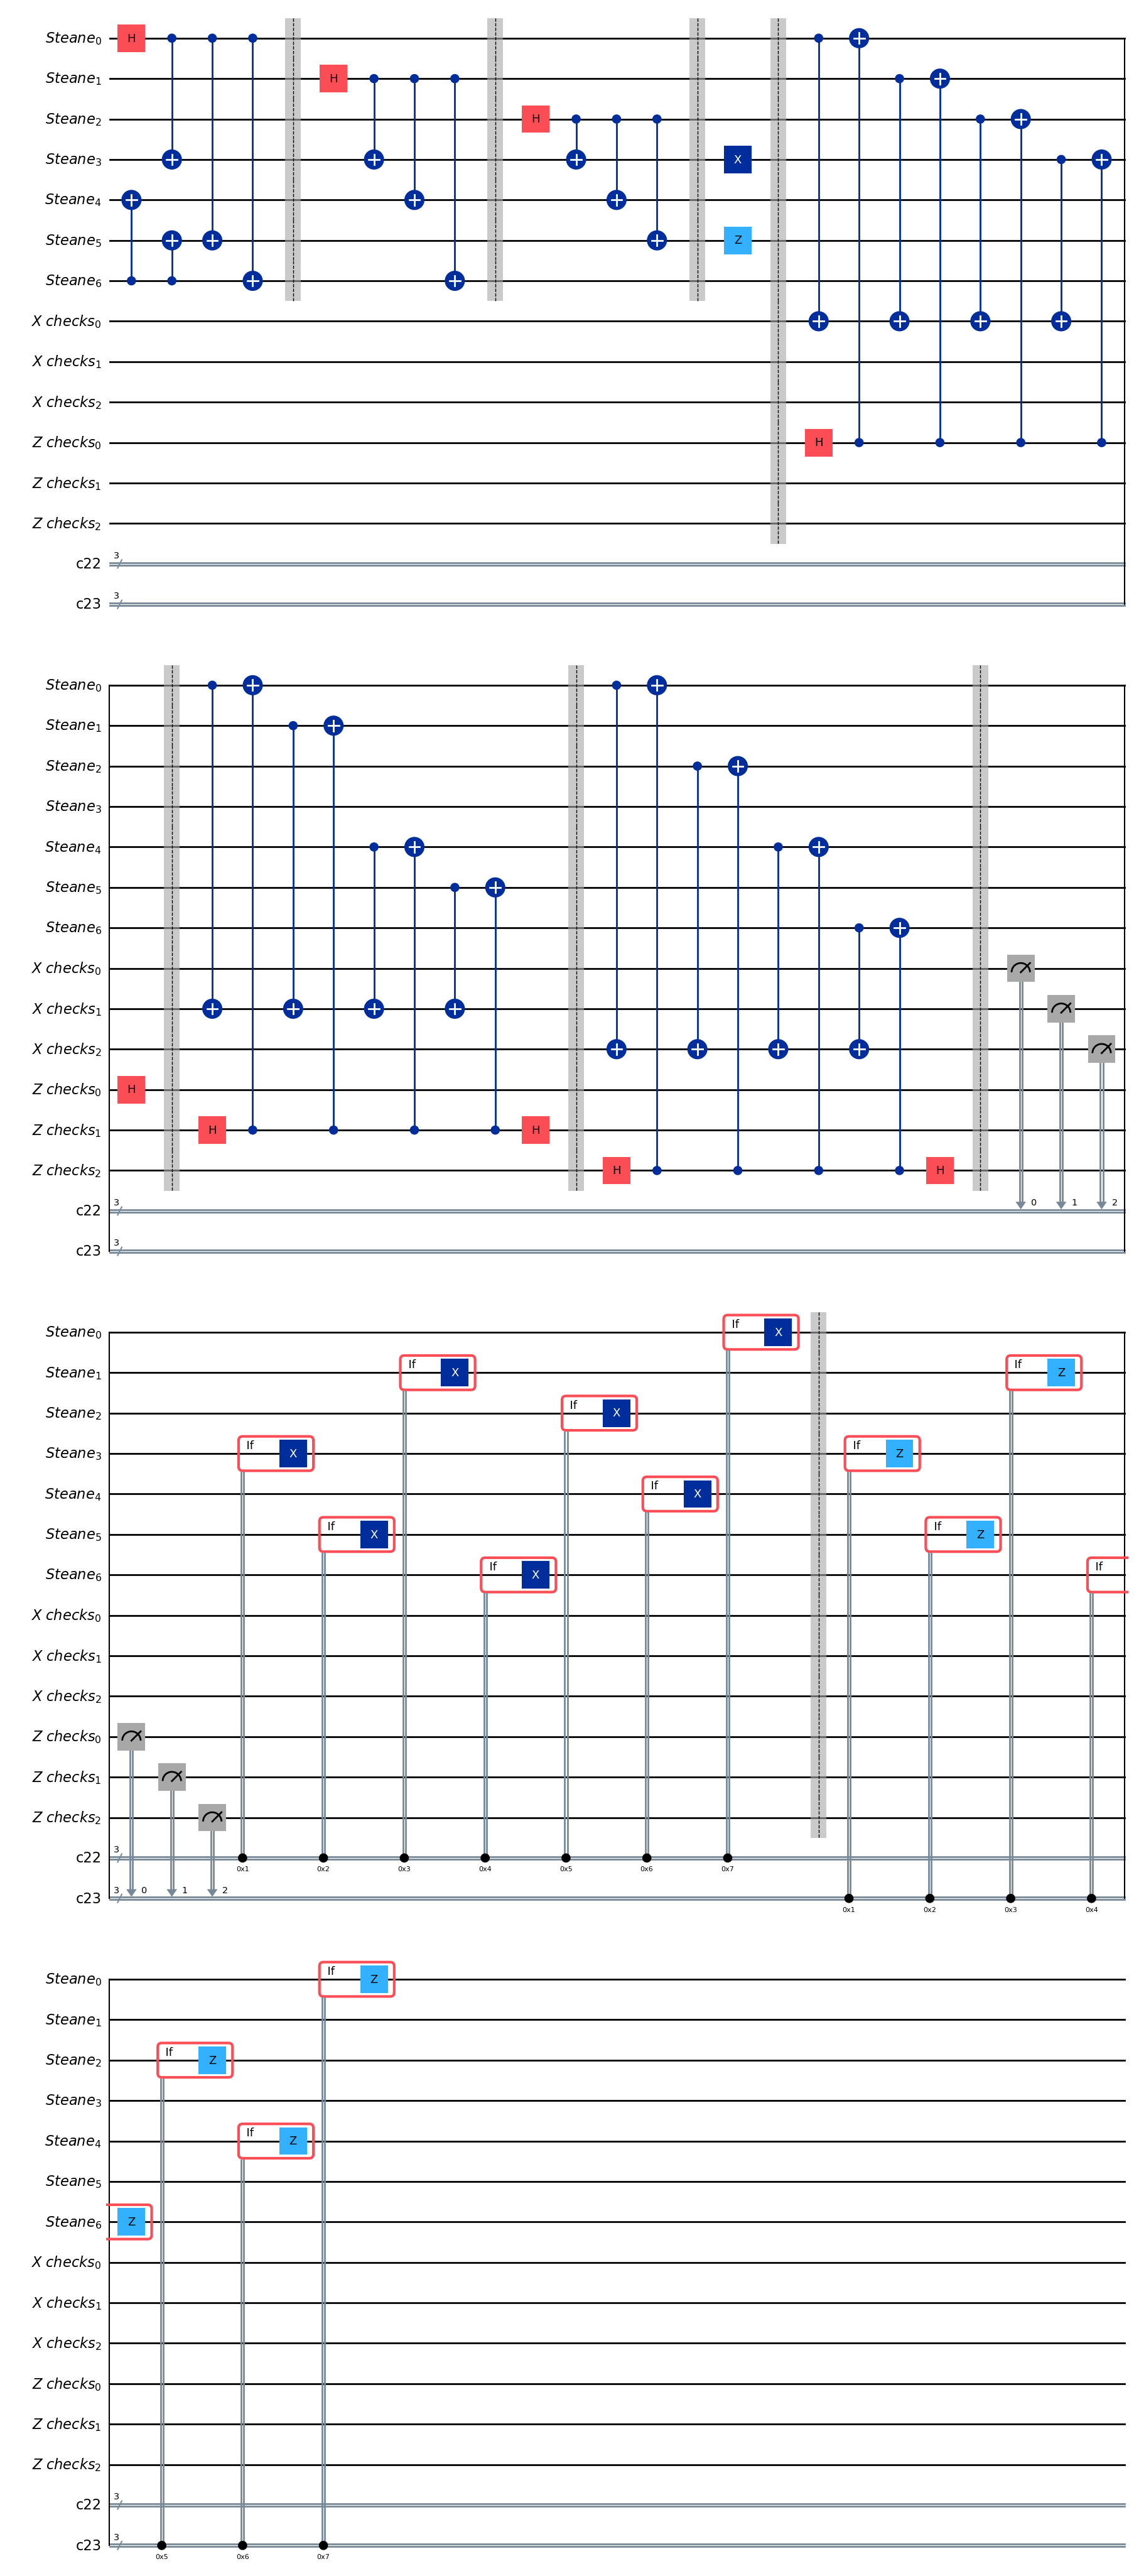

In [102]:
###                                           ### Determined via testing single qubit error
### Adding the X checks
with steane_code.if_test((X_syndromes, 1)):   ### X-syndrome = 1 (001) corresponds to X error on Qubit 3  
    steane_code.x(qubits_for_steane[3])       ### Fix: Apply an X gate to Qubit 3.

with steane_code.if_test((X_syndromes, 2)):   ### X-syndrome = 2 (010) corresponds to X error on Qubit 5 
    steane_code.x(qubits_for_steane[5])       ### Fix: Apply an X gate to Qubit 5.                                 

with steane_code.if_test((X_syndromes, 3)):   ### X-syndrome = 3 (011) corresponds to X error on Qubit 1 
    steane_code.x(qubits_for_steane[1])       ### Fix: Apply an X gate to Qubit 1.

with steane_code.if_test((X_syndromes, 4)):   ### X-syndrome = 4 (100) corresponds to X error on Qubit 6
    steane_code.x(qubits_for_steane[6])       ### Fix: Apply an X gate to Qubit 6.

with steane_code.if_test((X_syndromes, 5)):   ### X-syndrome = 5 (101) corresponds to X error on Qubit 2
    steane_code.x(qubits_for_steane[2])       ### Fix: Apply an X gate to Qubit 2.                                 

with steane_code.if_test((X_syndromes, 6)):   ### X-syndrome = 6 (110) corresponds to X error on Qubit 4
    steane_code.x(qubits_for_steane[4])       ### Fix: Apply an X gate to Qubit 4.  

with steane_code.if_test((X_syndromes, 7)):   ### X-syndrome = 7 (111) corresponds to X error on Qubit 0
    steane_code.x(qubits_for_steane[0])       ### Fix: Apply an X gate to Qubit 0.  

steane_code.barrier()

### Adding the Z checks
with steane_code.if_test((Z_syndromes, 1)):   ### Z-syndromes correspond to X-syndromes due to H_X=H_Z 
    steane_code.z(qubits_for_steane[3])

with steane_code.if_test((Z_syndromes, 2)):
    steane_code.z(qubits_for_steane[5])

with steane_code.if_test((Z_syndromes, 3)):
    steane_code.z(qubits_for_steane[1])

with steane_code.if_test((Z_syndromes, 4)):
    steane_code.z(qubits_for_steane[6])

with steane_code.if_test((Z_syndromes, 5)):
    steane_code.z(qubits_for_steane[2])

with steane_code.if_test((Z_syndromes, 6)):
    steane_code.z(qubits_for_steane[4])

with steane_code.if_test((Z_syndromes, 7)):
    steane_code.z(qubits_for_steane[0])

steane_code.draw(output="mpl")

In [103]:
## Last, we decode the resulting corrected code from the above recovery circuit.

steane_code.compose(steane_decode, inplace = True)

Now we will incorporate measurements on our Steane qubits to see if our syndrome and recovery circuits correctly detected and fixed the error we introduced to our code.

 ## Measuring the data qubits

 Now we want to measure code qubits (Steane_0 to Steane_6) to simulate how the receiver
 of our transmitted code would "read" what we sent to them.

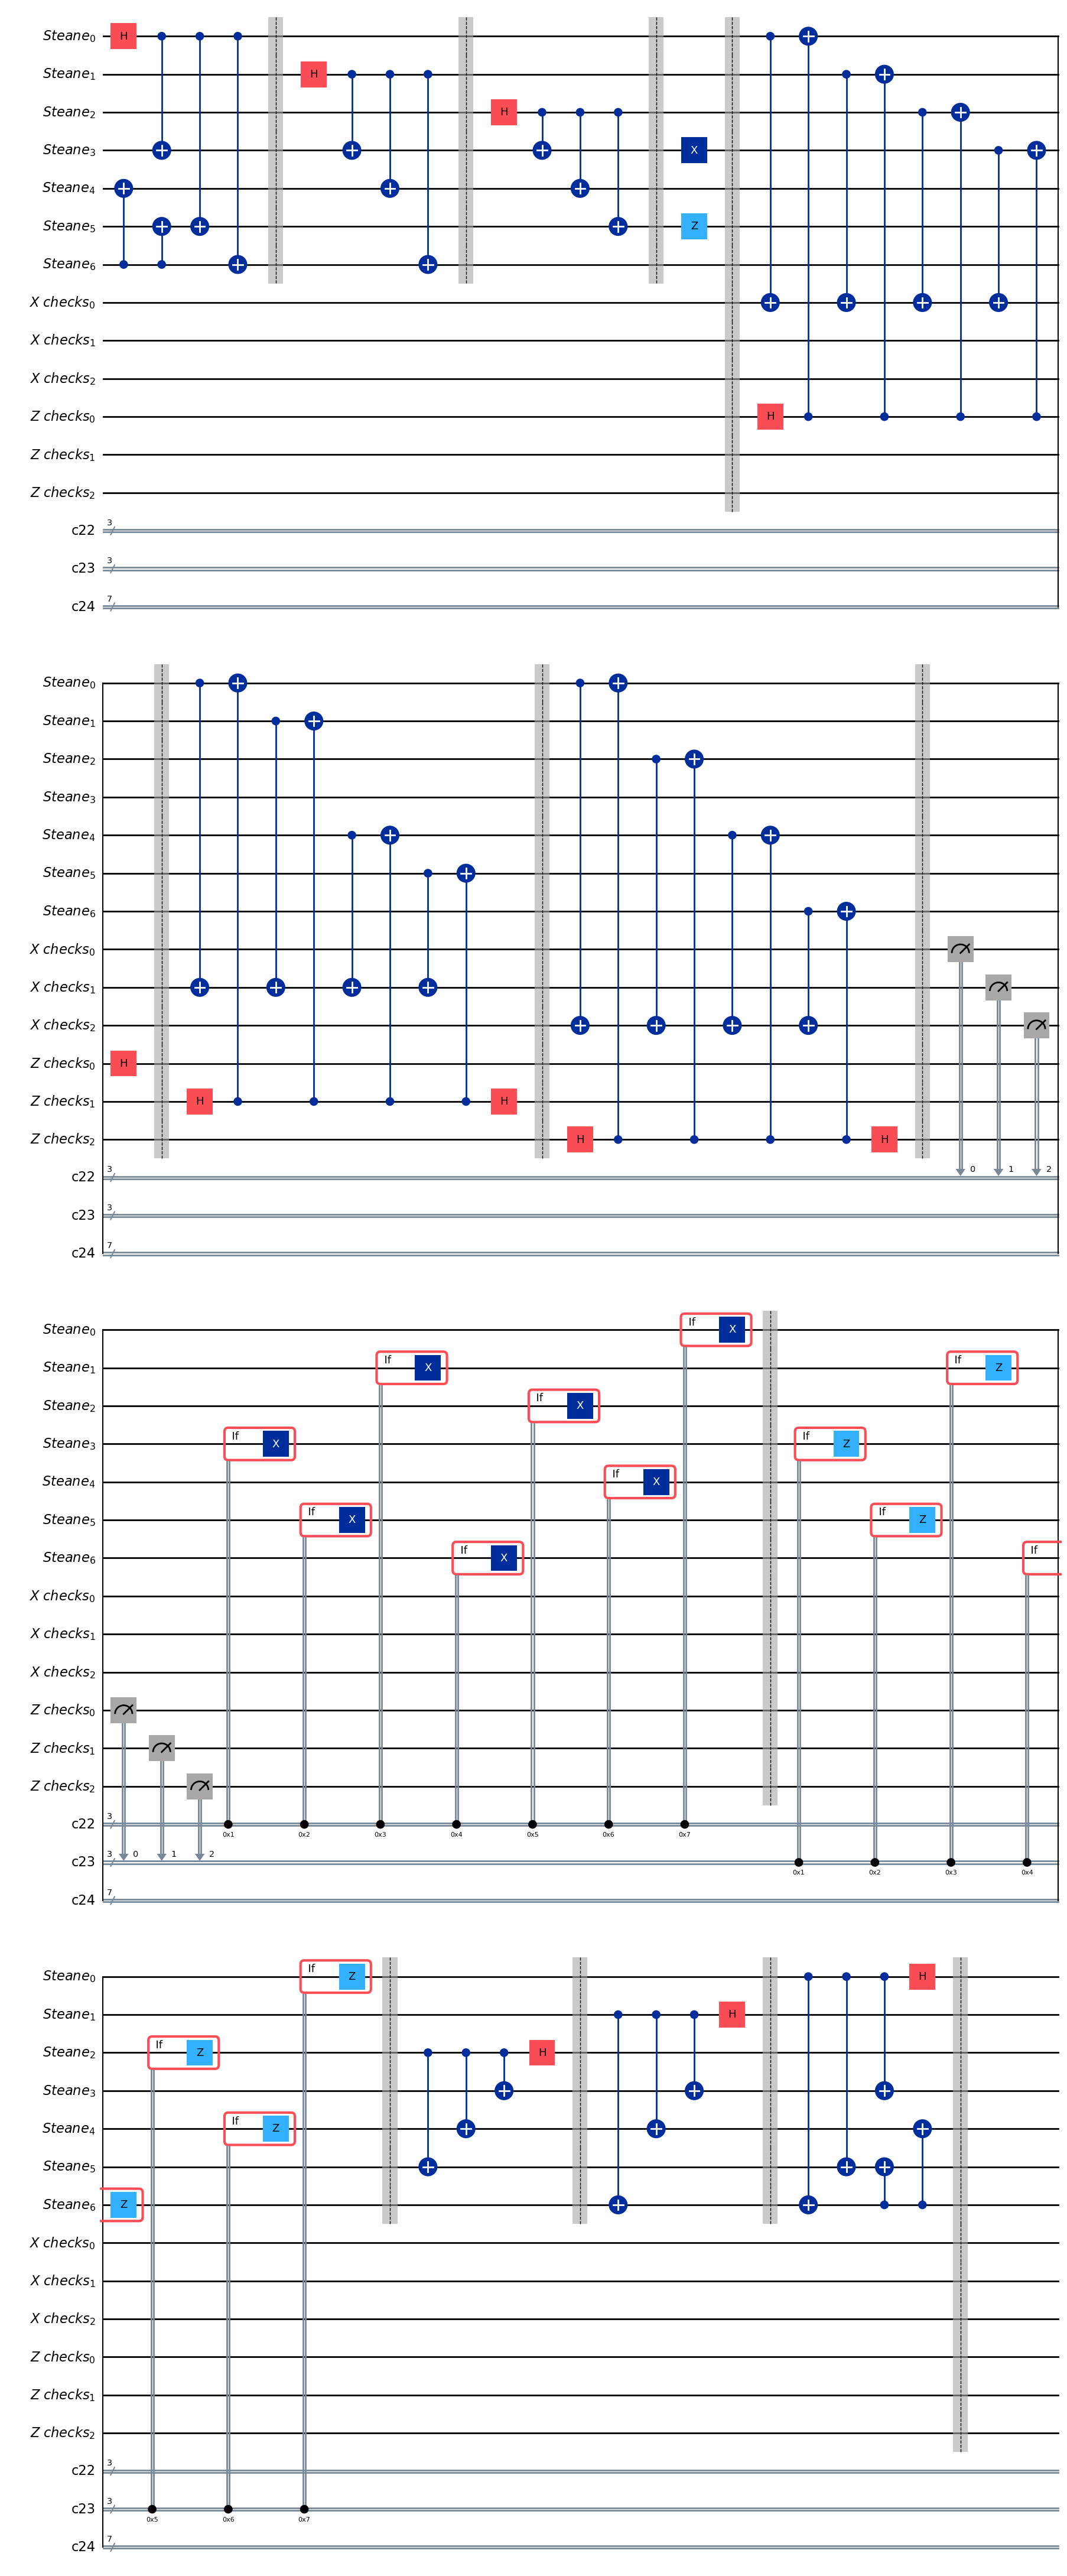

In [104]:
# For each data bit, add a classical bit for data

qubit_measurements = ClassicalRegister(7)
steane_code.add_register(qubit_measurements)

steane_code.barrier()
# Measuring
#steane_code.measure(qubits_for_steane, qubit_measurements)

steane_code.draw(output="mpl")

### Analysis of our error correcting circuit via simulation

In [105]:
simulator = AerSimulator()

In [106]:
rounds = 100
# Transpile the circuit for the backend
compiled_circuit = transpile(steane_code, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=rounds)

# Get the measurement counts
counts = job.result().get_counts()

In [107]:
distribution = {}
for measurement in counts:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts[measurement] / rounds

distribution
counts

{'0000000 010 001': 100}

### Conclusion

Recall $|0_L\rangle$ for our code is
$$
 \frac{\sqrt{2}}{4}\left(|0000000\rangle+
 ∣0001111⟩+
 ∣0110011⟩+
 ∣0111100⟩+
 ∣1010101⟩+
 ∣1011010⟩+
 ∣1100110⟩+
 ∣1101001⟩\right)
 $$
Given a (possibly incorrectly) corrected $E|0_L\rangle$, the *success probabilty* is defined to be the probabilty that you measure a component of the logical all-zero state at the end.

**Example 1**: When our Pauli error consisted of one X and one Z on different qubits with probability $p$ for each, we obtain a state which, although not in uniform distribution of the original eight computational basis vectors for $|0L\rangle$, was in superposition with precisely those eight basis vectors. Moreover, when we decoded and then simulated the errors occuring with probability $p$ on each qubit, the success probability was 100%.


**Example 2**: When the Pauli error consisted of two X gates on different qubits and one Z gate with probabiity $p$ for each, we decoded the state $|1000000\rangle$ 100% of the time, so our success probability was actually 0%.

## Simulating error correction for random Pauli noise

Now we incorporate random Pauli error with probability $p <1/3$. 


In [108]:
# P is the probability of independently adding an X, Y or Z error, independently per Qubit
P = 0.12

In [109]:
# Let's redefine our data qubit register and Steane code circuit.
# This is the last time we will redefine the circuit for this type of error.

qubits_for_steane = QuantumRegister(7, name = "Steane")
steane_code_pauli_error = QuantumCircuit(qubits_for_steane)
steane_code_pauli_error.compose(steane_encode, inplace=True) 

loc= 0 aux= [0 0 1]
loc= 1 aux= [0 0 0]
loc= 2 aux= [0 0 0]
loc= 3 aux= [1 0 0]
loc= 4 aux= [0 0 0]
loc= 5 aux= [0 0 0]
loc= 6 aux= [0 0 0]


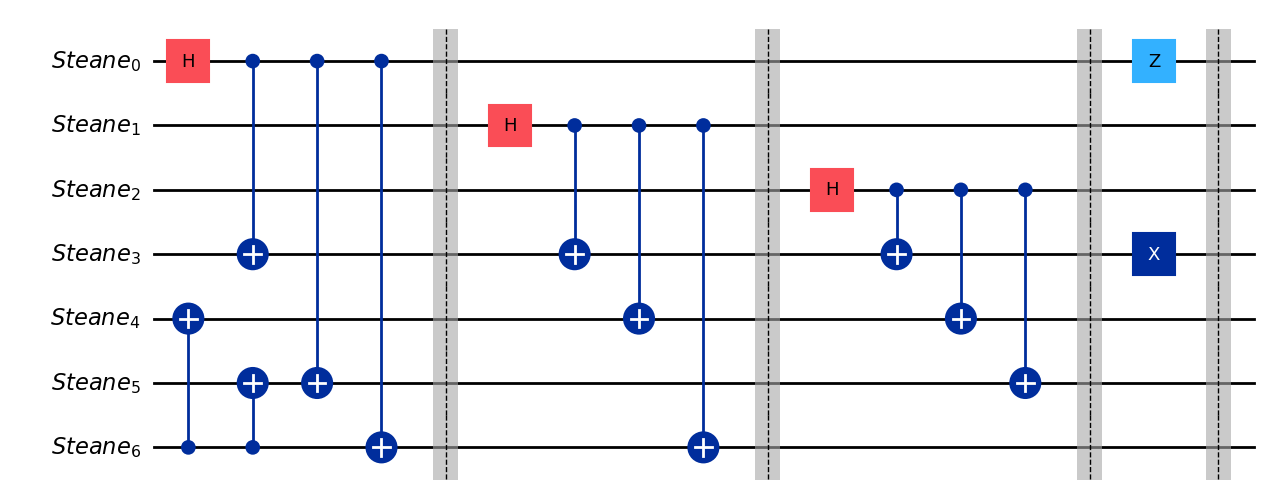

In [110]:

# add a random X, Y, Z Error independently per qubit
aux=0

for loc in range(7):
    aux = np.random.binomial(size=3, n=1, p=P) # This is a Bernouli random variable with probability p
    print('loc=', loc, 'aux=', aux)
    if aux[0] == 1:
        steane_code_pauli_error.x(qubits_for_steane[loc]) 
    if aux[1] == 1:
        steane_code_pauli_error.y(qubits_for_steane[loc])    
    if aux[2] == 1:
        steane_code_pauli_error.z(qubits_for_steane[loc])    

steane_code_pauli_error.barrier()
steane_code_pauli_error.draw(output="mpl")

### Syndrome Circuit

In [111]:
# Adding ancillas for syndromes
qubits_for_X_checks = AncillaRegister(size=3)
qubits_for_Z_checks = AncillaRegister(size=3)
### Is it not necessary to add another layer to correct Y errors since
### XZ = -ZX = iY, the X and Z correction will take care of it as is.

steane_code.add_register(qubits_for_X_checks, qubits_for_Z_checks)

# Extracting sydromes
for idx, row in enumerate(H):
    steane_code.h(qubits_for_Z_checks[idx])
    for qubit in np.where(row)[0]:
        steane_code.cx(qubit, qubits_for_X_checks[idx]) # X check
        steane_code.cx(qubits_for_Z_checks[idx], qubit) # Z check

    steane_code.h(qubits_for_Z_checks[idx])
    steane_code.barrier()



In [112]:
### Add classical bits for storing syndromes

X_syndromes = ClassicalRegister(3)
Z_syndromes = ClassicalRegister(3)
steane_code.add_register(X_syndromes, Z_syndromes)


### Measure

steane_code.measure(qubits_for_X_checks, X_syndromes)
steane_code.measure(qubits_for_Z_checks, Z_syndromes)

## Recovery operations (copied from earlier)

In [ ]:

### Adding the X checks
with steane_code.if_test((X_syndromes, 1)):   
    steane_code.x(qubits_for_steane[3])       

with steane_code.if_test((X_syndromes, 2)):
    steane_code.x(qubits_for_steane[5])                                          

with steane_code.if_test((X_syndromes, 3)):   
    steane_code.x(qubits_for_steane[1])       

with steane_code.if_test((X_syndromes, 4)):   
    steane_code.x(qubits_for_steane[6])                                      

with steane_code.if_test((X_syndromes, 5)):
    steane_code.x(qubits_for_steane[2])                                         

with steane_code.if_test((X_syndromes, 6)):                                      
    steane_code.x(qubits_for_steane[4])                                           

with steane_code.if_test((X_syndromes, 7)):    
    steane_code.x(qubits_for_steane[0])         

steane_code.barrier()

### Adding the Z checks
with steane_code.if_test((Z_syndromes, 1)):
    steane_code.z(qubits_for_steane[3])

with steane_code.if_test((Z_syndromes, 2)):
    steane_code.z(qubits_for_steane[5])

with steane_code.if_test((Z_syndromes, 3)):
    steane_code.z(qubits_for_steane[1])

with steane_code.if_test((Z_syndromes, 4)):
    steane_code.z(qubits_for_steane[6])

with steane_code.if_test((Z_syndromes, 5)):
    steane_code.z(qubits_for_steane[2])

with steane_code.if_test((Z_syndromes, 6)):
    steane_code.z(qubits_for_steane[4])

with steane_code.if_test((Z_syndromes, 7)):
    steane_code.z(qubits_for_steane[0])

### Decode and measure data bits

In [114]:
steane_code.compose(steane_decode, inplace = True)

qubit_measurements = ClassicalRegister(7)
steane_code.add_register(qubit_measurements)

steane_code.barrier()
# Measuring
steane_code.measure(qubits_for_steane, qubit_measurements)

In [115]:
simulator = AerSimulator()

In [116]:
rounds = 30
# Transpile the circuit for the backend
compiled_circuit = transpile(steane_code, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=rounds)

# Get the measurement counts
counts = job.result().get_counts()

In [118]:
distribution = {}
for measurement in counts:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts[measurement] / rounds

distribution


{'0000000': 1.0}